# CFP Visualization Report

This notebook provides comprehensive analysis and visualization of:

**1. Schedule Inequality**
- Conference schedule imbalance
- Teams with toughest/easiest schedules

**2. Ranking Stability**
- Week-over-week changes
- Trajectory plots for Top 25

**3. Prediction Error Analysis**
- Model accuracy metrics
- Residual distribution
- RMSE calculation

**4. Home Field Advantage Impact**
- Home vs away performance
- HFA adjustment validation

In [4]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import defaultdict

# Import metrics module
import sys
sys.path.insert(0, os.path.abspath('..'))

from src.utils.metrics import calculate_schedule_inequality_index

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Configuration
year = 2025
week = 15

# Output directory
output_dir = Path('./data/output')
viz_dir = output_dir / 'visualizations'
viz_dir.mkdir(parents=True, exist_ok=True)

print(f'Season: {year}, Week: {week}')
print(f'Visualization output: {viz_dir}')

Season: 2025, Week: 15
Visualization output: data/output/visualizations


In [5]:
# Cell 2: Load Data
# Load final composite rankings
rankings_df = pd.read_csv(output_dir / 'rankings' / f'composite_rankings_{year}_week{week}.csv')

# Load games data
def load_cached_games(year, week):
    cache_dir = f'./data/cache/{year}'
    parquet_path = f'{cache_dir}/games_w{week}.parquet'
    csv_path = f'{cache_dir}/games_w{week}.csv'
    
    if os.path.exists(parquet_path):
        try:
            return pd.read_parquet(parquet_path)
        except (ImportError, ModuleNotFoundError):
            pass
    
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    
    raise FileNotFoundError(f'No cached data found')

games_df = load_cached_games(year, week)

print(f'Loaded {len(rankings_df)} teams')
print(f'Loaded {len(games_df)} games')

Loaded 136 teams
Loaded 557 games


---

## 1. Schedule Inequality Analysis

In [6]:
# Cell 3: Calculate Schedule Inequality by Conference
# Get team conferences from games data
team_conferences = {}
for _, game in games_df.iterrows():
    if 'home_conference' in game:
        team_conferences[game['home_team']] = game['home_conference']
        team_conferences[game['away_team']] = game['away_conference']

# Group teams by conference
conferences = defaultdict(list)
for team, conf in team_conferences.items():
    if conf:  # Only include teams with conferences
        conferences[conf].append(team)

# Calculate inequality index for each conference
conf_inequality = {}
conf_sos_data = {}

for conf, teams in conferences.items():
    if len(teams) < 2:
        continue
    
    # Get SOS scores for teams in this conference
    conf_sos = {}
    for team in teams:
        team_row = rankings_df[rankings_df['team'] == team]
        if not team_row.empty:
            conf_sos[team] = team_row.iloc[0]['sos']
    
    if len(conf_sos) >= 2:
        inequality = calculate_schedule_inequality_index(conf_sos)
        conf_inequality[conf] = inequality
        conf_sos_data[conf] = conf_sos

# Sort by inequality
sorted_inequality = sorted(conf_inequality.items(), key=lambda x: x[1], reverse=True)

print('='*80)
print('CONFERENCE SCHEDULE INEQUALITY')
print('='*80)
print()
print('Higher inequality = more unbalanced schedules within conference')
print()
for conf, ineq in sorted_inequality[:10]:
    print(f'{conf:30} {ineq:.4f}')

CONFERENCE SCHEDULE INEQUALITY

Higher inequality = more unbalanced schedules within conference

Big Ten                        0.0625
SEC                            0.0497
American Athletic              0.0471
Mountain West                  0.0428
Big 12                         0.0384
Conference USA                 0.0360
Mid-American                   0.0331
ACC                            0.0327
Pac-12                         0.0318
Sun Belt                       0.0262


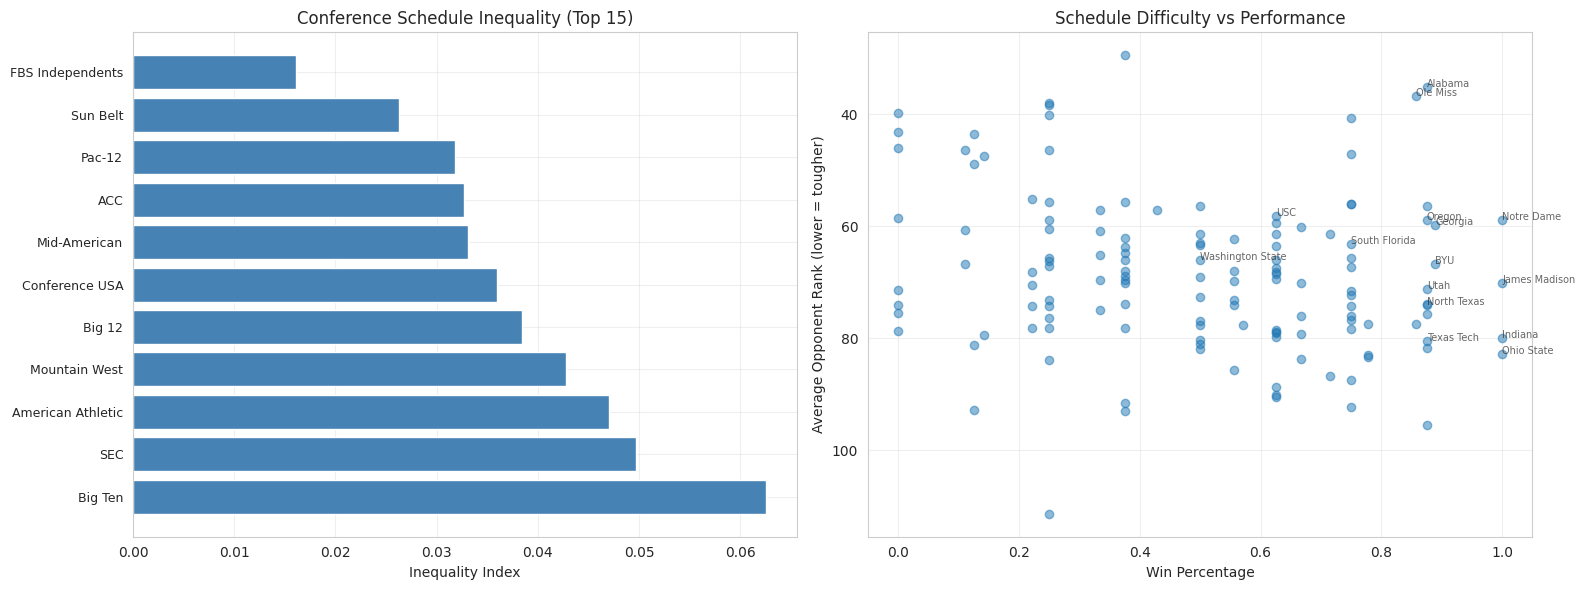

Saved: data/output/visualizations/schedule_inequality_2025.png


In [7]:
# Cell 4: Visualize Schedule Inequality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Conference inequality bar chart
ax1 = axes[0]
confs = [c for c, _ in sorted_inequality[:15]]
ineqs = [i for _, i in sorted_inequality[:15]]

ax1.barh(range(len(confs)), ineqs, color='steelblue')
ax1.set_yticks(range(len(confs)))
ax1.set_yticklabels(confs, fontsize=9)
ax1.set_xlabel('Inequality Index')
ax1.set_title('Conference Schedule Inequality (Top 15)')
ax1.grid(True, alpha=0.3)

# Plot 2: Win% vs Avg Opponent Rank
ax2 = axes[1]

# Calculate average opponent rank for each team
avg_opp_ranks = {}
for team in rankings_df['team']:
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    opp_ranks = []
    
    for _, game in team_games.iterrows():
        opponent = game['away_team'] if game['home_team'] == team else game['home_team']
        opp_row = rankings_df[rankings_df['team'] == opponent]
        if not opp_row.empty:
            opp_ranks.append(opp_row.iloc[0]['rank'])
    
    if opp_ranks:
        avg_opp_ranks[team] = np.mean(opp_ranks)

# Add to rankings for plotting
rankings_df['avg_opp_rank'] = rankings_df['team'].map(avg_opp_ranks)
rankings_df['win_pct'] = rankings_df['wins'] / (rankings_df['wins'] + rankings_df['losses'])

ax2.scatter(rankings_df['win_pct'], rankings_df['avg_opp_rank'], alpha=0.5)

# Annotate top 15
top15 = rankings_df.head(15)
for _, row in top15.iterrows():
    if pd.notna(row['avg_opp_rank']):
        ax2.annotate(row['team'], (row['win_pct'], row['avg_opp_rank']), 
                    fontsize=7, alpha=0.7)

ax2.set_xlabel('Win Percentage')
ax2.set_ylabel('Average Opponent Rank (lower = tougher)')
ax2.set_title('Schedule Difficulty vs Performance')
ax2.invert_yaxis()  # Better teams = lower rank
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / f'schedule_inequality_{year}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Saved: {viz_dir}/schedule_inequality_{year}.png')

---

## 2. Ranking Stability Over Time

In [8]:
# Cell 5: Load Historical Rankings (if available)
# Try to load rankings from previous weeks
historical_rankings = {}

for w in range(5, week + 1):  # Start from week 5 to avoid early season noise
    rankings_file = output_dir / 'rankings' / f'composite_rankings_{year}_week{w}.csv'
    if rankings_file.exists():
        historical_rankings[w] = pd.read_csv(rankings_file)

print(f'Loaded historical rankings for {len(historical_rankings)} weeks')
print(f'Weeks available: {sorted(historical_rankings.keys())}')

if len(historical_rankings) < 2:
    print()
    print('Note: Need rankings from multiple weeks for stability analysis.')
    print('Run previous weeks\' analyses to build historical data.')

Loaded historical rankings for 1 weeks
Weeks available: [15]

Note: Need rankings from multiple weeks for stability analysis.
Run previous weeks' analyses to build historical data.


In [9]:
# Cell 6: Visualize Ranking Trajectories
if len(historical_rankings) >= 2:
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Get current top 25
    current_top25 = rankings_df.head(25)['team'].tolist()
    
    # Track each team's trajectory
    for team in current_top25:
        weeks = []
        ranks = []
        
        for w, df in sorted(historical_rankings.items()):
            team_row = df[df['team'] == team]
            if not team_row.empty:
                weeks.append(w)
                ranks.append(team_row.iloc[0]['rank'])
        
        if len(weeks) >= 2:
            ax.plot(weeks, ranks, marker='o', label=team, alpha=0.7, linewidth=2)
    
    ax.invert_yaxis()
    ax.set_xlabel('Week', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)
    ax.set_title(f'Top 25 Ranking Trajectories - {year} Season', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.set_ylim(26, 0)
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'ranking_stability_{year}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Saved: {viz_dir}/ranking_stability_{year}.png')
else:
    print('Skipping trajectory plot - need multiple weeks of data')

Skipping trajectory plot - need multiple weeks of data


In [10]:
# Cell 7: Calculate Week-over-Week Volatility
if len(historical_rankings) >= 2:
    weeks = sorted(historical_rankings.keys())
    volatility_scores = []
    
    for i in range(1, len(weeks)):
        prev_week = weeks[i-1]
        curr_week = weeks[i]
        
        prev_df = historical_rankings[prev_week]
        curr_df = historical_rankings[curr_week]
        
        # Calculate rank changes
        rank_changes = []
        for team in curr_df['team']:
            curr_rank = curr_df[curr_df['team'] == team].iloc[0]['rank']
            prev_row = prev_df[prev_df['team'] == team]
            
            if not prev_row.empty:
                prev_rank = prev_row.iloc[0]['rank']
                rank_changes.append(abs(curr_rank - prev_rank))
        
        if rank_changes:
            avg_change = np.mean(rank_changes)
            volatility_scores.append((curr_week, avg_change))
    
    print('='*80)
    print('WEEK-OVER-WEEK VOLATILITY')
    print('='*80)
    print()
    print('Average rank change by week:')
    for w, vol in volatility_scores:
        print(f'  Week {w}: {vol:.2f} positions')
    
    if volatility_scores:
        overall_avg = np.mean([v for _, v in volatility_scores])
        print()
        print(f'Overall average volatility: {overall_avg:.2f} positions per week')
else:
    print('Skipping volatility analysis - need multiple weeks of data')

Skipping volatility analysis - need multiple weeks of data


---

## 3. Prediction Error Analysis

In [11]:
# Cell 8: Calculate Prediction Errors
# Load predictive rankings
predictive_rankings = pd.read_csv(output_dir / 'rankings' / f'predictive_rankings_{year}_week{week}.csv')

# Create rating dictionary for predictions
massey_ratings = dict(zip(predictive_rankings['team'], predictive_rankings['massey_rating']))

# Calculate prediction errors
residuals = []
predicted_margins = []
actual_margins = []

for _, game in games_df.iterrows():
    home = game['home_team']
    away = game['away_team']
    
    if home in massey_ratings and away in massey_ratings:
        # Predict margin using Massey ratings
        home_rating = massey_ratings[home]
        away_rating = massey_ratings[away]
        
        # Add HFA if not neutral site
        hfa = 0 if game['neutral_site'] else 3.75
        predicted_margin = (home_rating - away_rating) + hfa
        
        # Actual margin
        actual_margin = game['home_score'] - game['away_score']
        
        # Calculate residual
        residual = actual_margin - predicted_margin
        
        residuals.append(residual)
        predicted_margins.append(predicted_margin)
        actual_margins.append(actual_margin)

residuals = np.array(residuals)

# Calculate error metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
median_error = np.median(np.abs(residuals))

print('='*80)
print('PREDICTION ERROR METRICS')
print('='*80)
print()
print(f'Total games predicted: {len(residuals)}')
print(f'Mean Absolute Error (MAE): {mae:.2f} points')
print(f'Root Mean Square Error (RMSE): {rmse:.2f} points')
print(f'Median Absolute Error: {median_error:.2f} points')
print()
print(f'Standard deviation of errors: {np.std(residuals):.2f} points')
print(f'Mean residual (bias): {np.mean(residuals):.2f} points')

PREDICTION ERROR METRICS

Total games predicted: 557
Mean Absolute Error (MAE): 10.18 points
Root Mean Square Error (RMSE): 13.00 points
Median Absolute Error: 8.01 points

Standard deviation of errors: 13.00 points
Mean residual (bias): -0.25 points


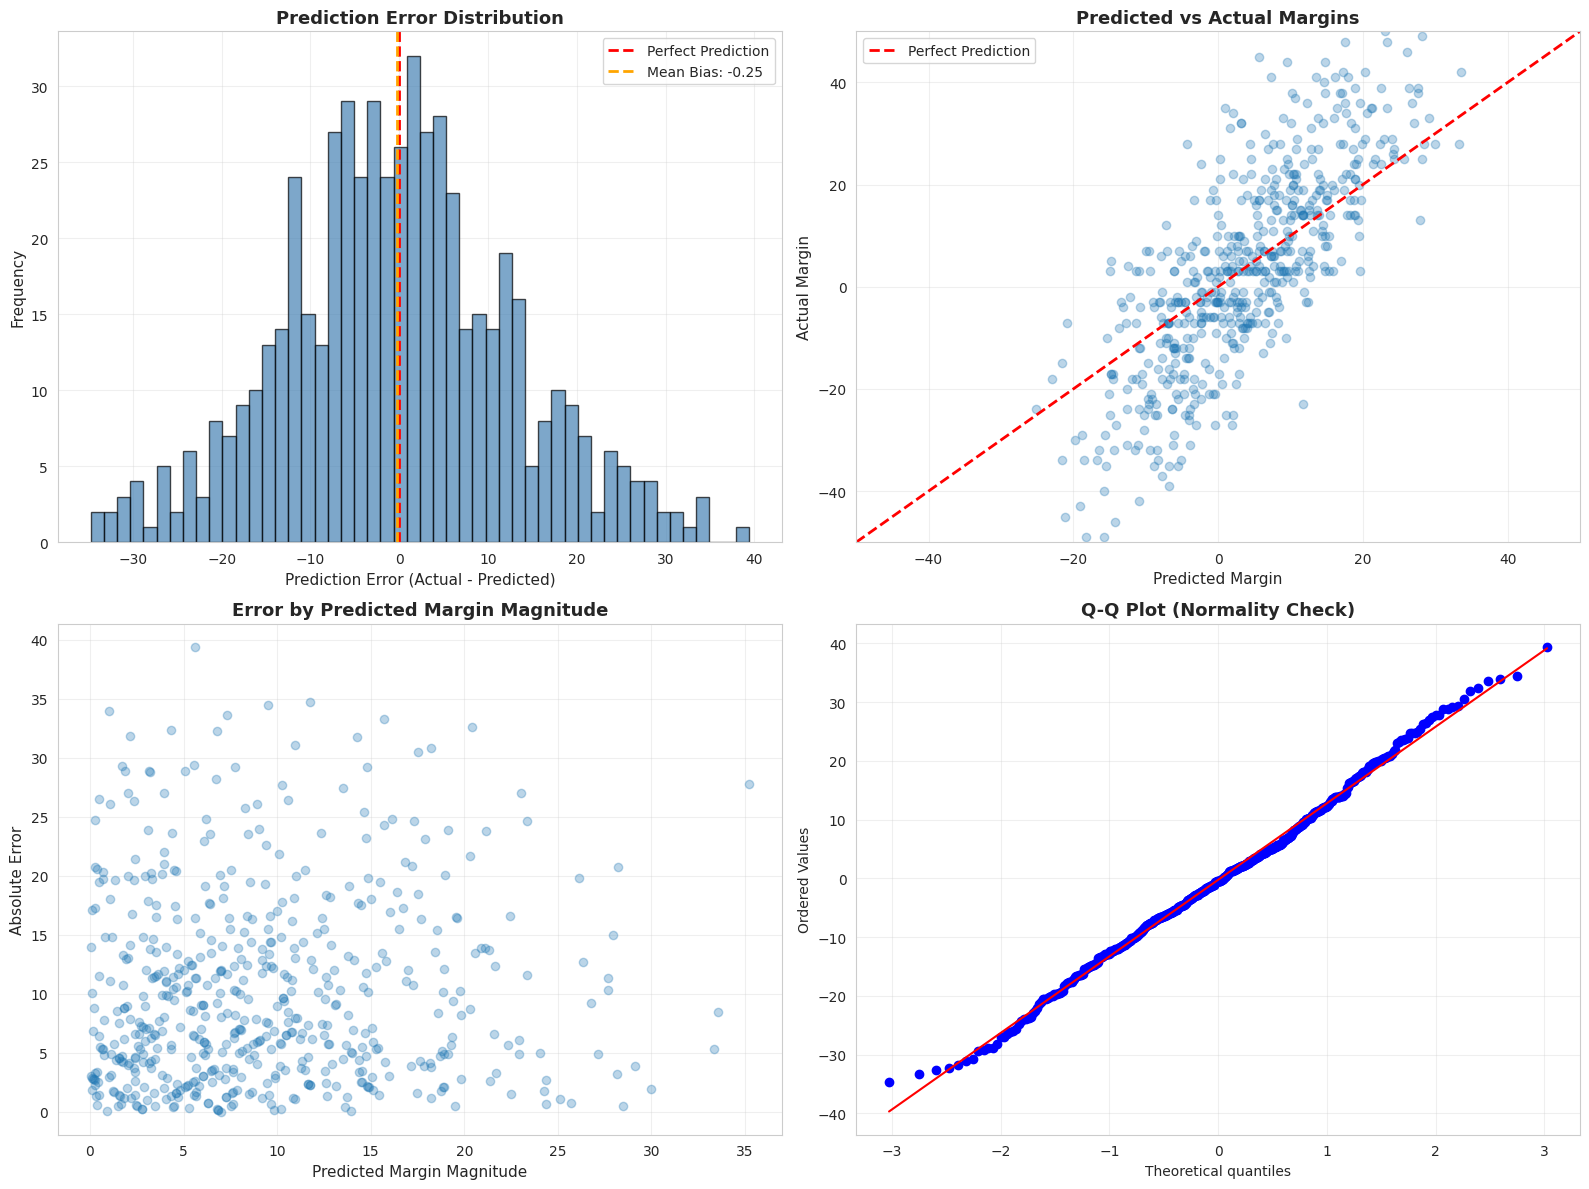

Saved: data/output/visualizations/prediction_errors_2025.png


In [12]:
# Cell 9: Visualize Prediction Errors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Residual distribution
ax1 = axes[0, 0]
ax1.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
ax1.axvline(np.mean(residuals), color='orange', linestyle='--', linewidth=2, label=f'Mean Bias: {np.mean(residuals):.2f}')
ax1.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual
ax2 = axes[0, 1]
ax2.scatter(predicted_margins, actual_margins, alpha=0.3)
ax2.plot([-50, 50], [-50, 50], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Predicted Margin', fontsize=11)
ax2.set_ylabel('Actual Margin', fontsize=11)
ax2.set_title('Predicted vs Actual Margins', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-50, 50)
ax2.set_ylim(-50, 50)

# Plot 3: Error by predicted margin magnitude
ax3 = axes[1, 0]
abs_predicted = np.abs(predicted_margins)
abs_errors = np.abs(residuals)
ax3.scatter(abs_predicted, abs_errors, alpha=0.3)
ax3.set_xlabel('Predicted Margin Magnitude', fontsize=11)
ax3.set_ylabel('Absolute Error', fontsize=11)
ax3.set_title('Error by Predicted Margin Magnitude', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Q-Q plot for normality
ax4 = axes[1, 1]
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist='norm', plot=ax4)
ax4.set_title('Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / f'prediction_errors_{year}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Saved: {viz_dir}/prediction_errors_{year}.png')

---

## 4. Home Field Advantage Analysis

In [13]:
# Cell 10: Analyze Home Field Advantage
# Split games by home/away/neutral
home_games = games_df[~games_df['neutral_site']]
neutral_games = games_df[games_df['neutral_site']]

# Calculate home win rate
home_wins = (home_games['home_score'] > home_games['away_score']).sum()
total_home_games = len(home_games)
home_win_pct = home_wins / total_home_games if total_home_games > 0 else 0

# Calculate neutral win rate (for "home" team designation)
neutral_wins = (neutral_games['home_score'] > neutral_games['away_score']).sum()
total_neutral_games = len(neutral_games)
neutral_win_pct = neutral_wins / total_neutral_games if total_neutral_games > 0 else 0

# Calculate average margins
home_margins = home_games['home_score'] - home_games['away_score']
neutral_margins = neutral_games['home_score'] - neutral_games['away_score']

avg_home_margin = home_margins.mean()
avg_neutral_margin = neutral_margins.mean()

print('='*80)
print('HOME FIELD ADVANTAGE ANALYSIS')
print('='*80)
print()
print(f'Home Games: {total_home_games}')
print(f'Home Win Rate: {home_win_pct:.1%}')
print(f'Average Home Margin: {avg_home_margin:.2f} points')
print()
print(f'Neutral Site Games: {total_neutral_games}')
print(f'Neutral "Home" Win Rate: {neutral_win_pct:.1%}')
print(f'Average Neutral Margin: {avg_neutral_margin:.2f} points')
print()
print(f'Implied HFA: {avg_home_margin - avg_neutral_margin:.2f} points')
print(f'Model HFA: 3.75 points')

HOME FIELD ADVANTAGE ANALYSIS

Home Games: 547
Home Win Rate: 57.2%
Average Home Margin: 3.56 points

Neutral Site Games: 10
Neutral "Home" Win Rate: 40.0%
Average Neutral Margin: -4.00 points

Implied HFA: 7.56 points
Model HFA: 3.75 points


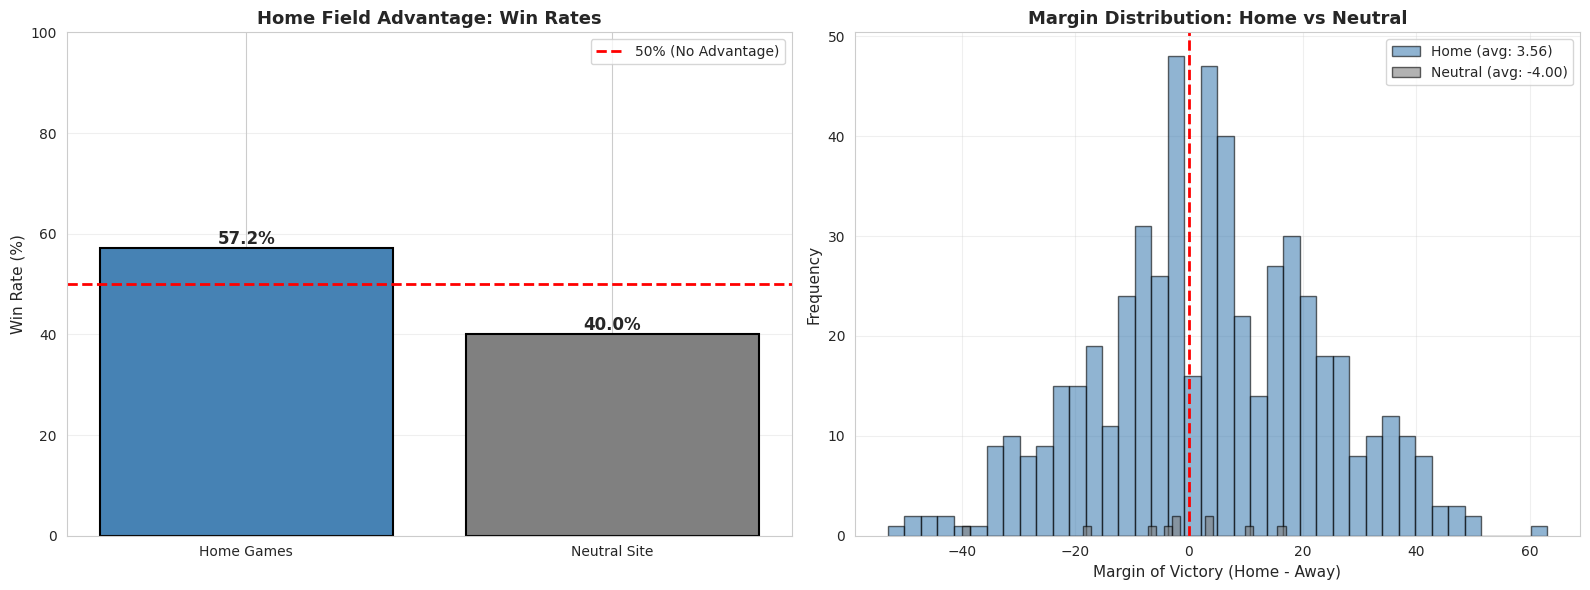

Saved: data/output/visualizations/home_field_advantage_2025.png


In [14]:
# Cell 11: Visualize Home Field Advantage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Win rate comparison
ax1 = axes[0]
locations = ['Home Games', 'Neutral Site']
win_rates = [home_win_pct * 100, neutral_win_pct * 100]
colors = ['steelblue', 'gray']

bars = ax1.bar(locations, win_rates, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(50, color='red', linestyle='--', linewidth=2, label='50% (No Advantage)')
ax1.set_ylabel('Win Rate (%)', fontsize=11)
ax1.set_title('Home Field Advantage: Win Rates', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Margin distribution comparison
ax2 = axes[1]
ax2.hist(home_margins, bins=40, alpha=0.6, label=f'Home (avg: {avg_home_margin:.2f})', color='steelblue', edgecolor='black')
ax2.hist(neutral_margins, bins=40, alpha=0.6, label=f'Neutral (avg: {avg_neutral_margin:.2f})', color='gray', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Margin of Victory (Home - Away)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Margin Distribution: Home vs Neutral', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / f'home_field_advantage_{year}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Saved: {viz_dir}/home_field_advantage_{year}.png')

---

## Summary

Visualization report complete!

**Outputs:**
- Schedule inequality analysis by conference
- Ranking stability trajectories over time
- Prediction error metrics and distribution
- Home field advantage validation

All visualizations saved to `data/output/visualizations/`

**Next Steps:**
- Review rankings for consistency
- Adjust weights if needed in configuration
- Run complete pipeline for final analysis